In [180]:
import numpy as np
import cv2 as cv
import os
from sklearn import svm
import matplotlib.pyplot as plt
import re

In [181]:
treinamentoDiretorio = "CAPTCHA-10k/treinamento"
labelsDiretorio = "CAPTCHA-10k/labels10k/"
validacaoDiretorio = "CAPTCHA-10k/validacao"

In [182]:
regioes = [35, 65, 95, 125, 155]
tamanhoDaRegiao = 2048

In [183]:
def padding_img(img: np.ndarray, colsSize: int):
    nLines, nCols = img.shape
    
    pad_row = 0
    pad_col = colsSize - nCols

    pad_width = ((0, pad_row), (0, pad_col)) # 
    return np.pad(img, pad_width, mode='maximum') 

In [184]:
def returna_regioes(img, regioes):
    img_regioes = []

    regioes = [5] + regioes + [img.shape[1]]

    for i in range(len(regioes)-1):
        img_regioes.append(img[:, regioes[i]:regioes[i+1]])


    return img_regioes


In [185]:
def dx(img):
    img = np.array(img, dtype=np.int64)
    M, N = img.shape

    DX = np.zeros((M-2, N-2), dtype=np.int64)

    for i in range(1, M-1):
        for j in range(1, N-1):
            DX[i-1][j-1] = np.subtract(img[i][j - 1], img[i][j + 1]) 
    return DX

def dy(img):
    img = np.array(img, dtype=np.int64)
    M, N = img.shape
    DY = np.zeros((M-2, N-2), dtype=np.int64)

    for i in range(1, M-1):
        for j in range(1, N-1):
            DY[i-1][j-1] = np.subtract(img[i-1][j], img[i+1][j])
    return DY

def gradient(img):
    DX = dx(img)
    DY = dy(img)
    
    magnitude = np.sqrt(DY**2 + DX**2)

    # avoid zero division
    DX = np.array(DX, dtype=np.float128)
    filter = DX == 0
    DX[filter] = 0.0001

    angle = (np.arctan(DY/DX))

    # transform negative angles to positive
    filter = angle < 0
    angle[filter] += np.pi

    # convert rad to angle
    angle *= 180/np.pi

    return magnitude, np.abs(angle)

def charactersGradient(chars):
    charGradient = []

    for char in chars:
        mag, angle = gradient(char)
        charGradient.append(
            {
                'magnitude': mag,
                'angle': angle
            }
        )
    
    return charGradient

def CaptchaToCharacters(captcha):
    char1 = captcha[:, 10:37]
    char2 = captcha[:, 37:68]
    char3 = captcha[:, 68:96]
    char4 = captcha[:, 98:127]
    char5 = captcha[:, 130:155]
    char6 = captcha[:, 153:]
    
    chars = [char1, char2, char3, char4, char5, char6]

    for i in range(len(chars)):
        chars[i] = padding_img(chars[i], 32)

    size = chars[i].size
    for i in range(len(chars)):
        char = chars[i]
        if size != char.size:
            print(f'Tamanho do referencia: {size}, char{i}: {char.size}')
            print("Caracters com tamanho direfente")
            exit(1)
            
    return chars

def hogChar(magnitude, angle):
    # This hog use a 2x2 windown where each cell has 8 px
    M, N = magnitude.shape

    M = M//4 - 1
    N = N//4 - 1

    # calculate the hog, 8x8 px
    hog8X8 = np.zeros((M*N*9, ))
    for i in range(M):
        for j in range(N):
            index = angle[i*4:i*4+8, j*4:j*4+8].flatten()/20
            m = magnitude[i*4:i*4+8, j*4:j*4+8].flatten()

            cellHist8X8 = np.zeros((9, ))

            for k in range(index.size):
                id = int(index[k]//1)
                idFraction = index[k] - id

                if id >= 8:
                    cellHist8X8[id] += m[k]
                else:
                    cellHist8X8[id] += (1 - idFraction) * m[k]
                    cellHist8X8[id + 1] += idFraction * m[k]
                
            normalized = cellHist8X8
            normalized /= np.sqrt((normalized**2).sum() + 0.1)
            hog8X8[(i*N + j)*9:(i*N + j)*9 + 9] = normalized
                
    return hog8X8
        

def hogCaptcha(captchaPATH):
    captcha = cv.imread(captchaPATH, cv.IMREAD_GRAYSCALE)
    captcha = np.array(captcha, dtype=np.int64)

    # magnitude, angle = gradient(captcha)

    chars = CaptchaToCharacters(captcha)
    charsGradient = charactersGradient(chars) 


    char1 = hogChar(charsGradient[0]['magnitude'], charsGradient[0]['angle'])
    char2 = hogChar(charsGradient[1]['magnitude'], charsGradient[1]['angle'])
    char3 = hogChar(charsGradient[2]['magnitude'], charsGradient[2]['angle'])
    char4 = hogChar(charsGradient[3]['magnitude'], charsGradient[3]['angle'])
    char5 = hogChar(charsGradient[4]['magnitude'], charsGradient[4]['angle'])
    char6 = hogChar(charsGradient[5]['magnitude'], charsGradient[5]['angle'])
    
    return np.array([char1, char2, char3, char4, char5, char6])


In [186]:
def hogFeaturesForTraining():
    features = []
    
    files = os.listdir(treinamentoDiretorio)
    
    for file in files:
        filePath = os.path.join(treinamentoDiretorio, file)

        describers = hogCaptcha(filePath)

        for i in describers:
            features.append(i)

    return np.asarray(features)


In [187]:

# Retorna as Labels de Treino
def getTrainingLabels():
    labelsArr = []
    files = os.listdir(treinamentoDiretorio)

    for file in files:
        # get the img label
        labelPATH = os.path.join(labelsDiretorio, file[:-4]+'.txt')
        labelFILE = open(labelPATH, 'r')
        label = labelFILE.read()
        labelFILE.close()

        label = label[0:6] if len(label) > 6 else label

        labelsArr += list(label)
    
    return np.asarray(labelsArr)


In [188]:
features = hogFeaturesForTraining()
labelsArr = getTrainingLabels()

features.shape, labelsArr.shape


((48000, 594), (48000,))

In [189]:
# Training phase
clf = svm.SVC()
clf.fit(features, labelsArr)

SVC()

# Validação


In [190]:
def validation(model):
    features = []
    files = os.listdir(validacaoDiretorio)
    
    for file in files:
        filePath = os.path.join(validacaoDiretorio, file)

        describers = hogCaptcha(filePath)
        
        for i in describers:
            features.append(i)

    features = np.asarray(features)
    predict = model.predict(features)


    labels = []
    files = os.listdir(validacaoDiretorio)

    for file in files:
        # get the img label
        labelPATH = os.path.join(labelsDiretorio, file[:-4]+'.txt')
        labelFILE = open(labelPATH, 'r')
        label = labelFILE.read()
        labelFILE.close()

        label = label[0:6] if len(label) > 6 else label

        labels += list(label)
    labels = np.asarray(labels)


    return (predict, labels)

predict, labels = validation(clf)

# Análise


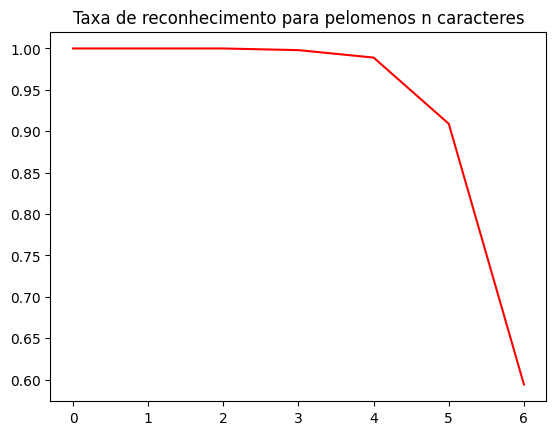

In [191]:
def numOfMatches(strA, strB):
    return (strA == strB).sum()

def createAnalitic(predict, labels):
    numCaptchas = len(labels) // 6

    histogram = [0, 0, 0, 0, 0, 0, 0]

    for i in range(numCaptchas):
        nMatch = numOfMatches(predict[i*6:i*6 + 6], labels[i*6:i*6 + 6])
        for j in range(nMatch + 1):
            histogram[j] += 1
    

    
    X = [0, 1, 2, 3, 4, 5, 6]
    histogram = np.asarray(histogram)
    histogram = histogram / histogram[0]
    plt.plot(X, histogram, '-r')
    plt.title("Taxa de reconhecimento para pelomenos n caracteres")
    plt.show()

createAnalitic(predict, labels)


In [192]:
a = (predict == labels).sum() / predict.size
print(a)
print(a**6)

0.915
0.5868492642057658


In [193]:
feat = hogCaptcha('./CAPTCHA-10k/validacao/008003.jpg')
feat.shape

(6, 594)

# mostrar Samu

In [194]:
def matches(strA, strB):
    return (strA == strB)

def histMatchPerCaracterPosition(predict, labels):
    numCaptchas = len(labels) // 6

    histogram = [0, 0, 0, 0, 0, 0]

    for i in range(numCaptchas):
        histogram += matches(predict[i*6:i*6 + 6], labels[i*6:i*6 + 6])

    histogram = np.asarray(histogram)
    histogram = histogram / 1000
    plt.plot(histogram, '*r')
    plt.title("Taxa de reconhecimento dos caracteres por posição")
    plt.show()

    return histogram


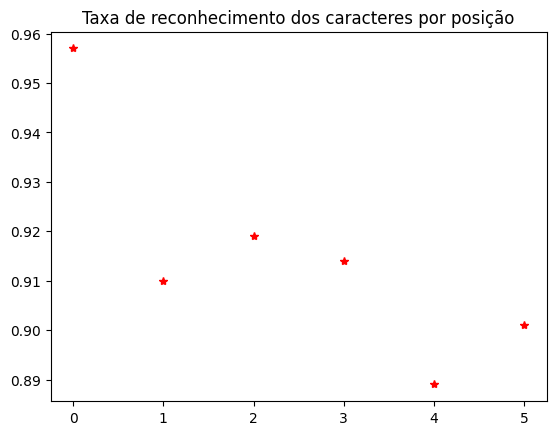

In [195]:
histogram = histMatchPerCaracterPosition(predict, labels)

In [196]:
histogram

array([0.957, 0.91 , 0.919, 0.914, 0.889, 0.901])

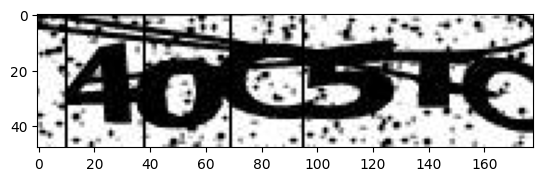

In [197]:
captcha = cv.imread('./CAPTCHA-10k/validacao/008016.jpg', cv.IMREAD_GRAYSCALE)
magnitude, angle = gradient(captcha)

a = captcha[1:-1, 1:-1]
a[:, 10] = 0
a[:, 38] = 0

# a[:, 37] = 0
a[:, 69] = 0
a[:, 95] = 0
# a[:, 100] = 0

# a[:, 125] = 0
# a[:, 130] = 0

# a[:, 153] = 0
# a[:, 155] = 0



plt.imshow(a, cmap='gray')
plt.show()

In [198]:


charsGradient = CaptchaToCharacters(magnitude, angle)

i = 5
plt.imshow(dx(charsGradient[i]['magnitude']), cmap='gray')
charsGradient[i]['magnitude'].shape

TypeError: CaptchaToCharacters() takes 1 positional argument but 2 were given